In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

Exception:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/shutil.py", line 544, in move
    os.rename(src, real_dst)
PermissionError: [Errno 13] Permission denied: '/opt/conda/lib/python3.6/site-packages/torch' -> '/tmp/pip-co420wml-uninstall/opt/conda/lib/python3.6/site-packages/torch'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/pip/basecommand.py", line 215, in main
    status = self.run(options, args)
  File "/opt/conda/lib/python3.6/site-packages/pip/commands/install.py", line 342, in run
    prefix=options.prefix_path,
  File "/opt/conda/lib/python3.6/site-packages/pip/req/req_set.py", line 778, in install
    requirement.uninstall(auto_confirm=True)
  File "/opt/conda/lib/python3.6/site-packages/pip/req/req_install.py", line 754, in uninstall
    paths_to_remove.remove(auto_confirm)
  File "/opt/conda/lib/python3.6/site-packages/pip/req/req_uninstall.py

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import pdb

PATH='./models/DC2_MNIST_'

# Size of feature map in discriminator
NDF = 16
# Size of feature map in Generator
NGF = 16
# Size of latent vector z (size of generator input)
NZ = 100
# Size of mini-batch
BS = 64
# Learning rate for Adam optimizer
LR = 0.0002
# Momentum value for Adam optimizer
BETA1 = 0.5
# Number of epoch
NUMEPOCHS = 20
# Number of channels of image
NC = 1



class Generator(nn.Module):
    """Build a Generative Network."""
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(NZ, NGF*8*4*4),
            nn.BatchNorm1d(NGF*8*4*4),
            nn.ReLU(inplace=True))
        
        self.main = nn.Sequential(          
            nn.ConvTranspose2d(NGF*8, NGF*4, 4, 2, 1),
            nn.BatchNorm2d(NGF*4),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(NGF*4, NGF*2, 4, 2, 1),
            nn.BatchNorm2d(NGF*2),
            nn.ReLU(inplace=True),
        
            nn.ConvTranspose2d(NGF*2, NC, 4, 2, 1),
            nn.Tanh())
    
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, NGF*8, 4, 4)
        x = self.main(x)
        return x


class Discriminator(nn.Module):
    """Build a Discriminative Network."""
    
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(NC, NDF, 4, 2, 1),
            nn.LeakyReLU(0.2,inplace=True),
        
            nn.Conv2d(NDF, NDF*2, 4, 2, 1),
            nn.BatchNorm2d(NDF*2),
            nn.LeakyReLU(0.2, inplace=True),
        
            nn.Conv2d(NDF*2, NDF*4, 4, 2, 1),
            nn.BatchNorm2d(NDF*4),
            nn.LeakyReLU(0.2, inplace=True))
        
        self.fc = nn.Sequential(
            nn.Linear(4*4*NDF*4, 1),
            nn.Sigmoid())

    def forward(self, img):
        x = self.main(img)
        x = x.view(-1, 4*4*NDF*4)
        x = self.fc(x)
        return x
    
        
def weights_init(m):
    layerName = m.__class__.__name__
    if layerName.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0.0)

    
def load_dataset(batchSize):
    """Load MNIST dataset."""
    transform = transforms.Compose(
        [transforms.Resize(32),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
    trainset = dset.MNIST(root='./data', train=True, 
                            download=True, transform=transform)
    testset = dset.MNIST(root='./data', train=False,
                           download=True, transform=transform)
    trainLoader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                              shuffle=True, num_workers=2)
    testLoader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                             shuffle=True, num_workers=2)
    return trainLoader, testLoader

[0/20][0/938]	Loss_D = 1.4248	Loss_G = 0.7053	D(x) = 0.5002	D(G(z)) = 0.5187 / 0.4956
[0/20][50/938]	Loss_D = 0.6452	Loss_G = 1.5768	D(x) = 0.8700	D(G(z)) = 0.2838 / 0.2048
[0/20][100/938]	Loss_D = 0.6468	Loss_G = 1.6744	D(x) = 0.8927	D(G(z)) = 0.0830 / 0.1868
[0/20][150/938]	Loss_D = 0.5013	Loss_G = 1.8139	D(x) = 0.9777	D(G(z)) = 0.1613 / 0.1623
[0/20][200/938]	Loss_D = 0.4419	Loss_G = 1.4355	D(x) = 0.9790	D(G(z)) = 0.1383 / 0.2401
[0/20][250/938]	Loss_D = 0.4970	Loss_G = 2.3098	D(x) = 0.9700	D(G(z)) = 0.0711 / 0.1003
[0/20][300/938]	Loss_D = 0.4968	Loss_G = 1.9476	D(x) = 0.9715	D(G(z)) = 0.2060 / 0.1432
[0/20][350/938]	Loss_D = 0.7143	Loss_G = 1.8554	D(x) = 0.8635	D(G(z)) = 0.0459 / 0.1575
[0/20][400/938]	Loss_D = 0.6018	Loss_G = 1.1979	D(x) = 0.9057	D(G(z)) = 0.0933 / 0.3022
[0/20][450/938]	Loss_D = 0.5040	Loss_G = 1.8703	D(x) = 0.9463	D(G(z)) = 0.1694 / 0.1552
[0/20][500/938]	Loss_D = 0.5233	Loss_G = 1.9914	D(x) = 0.9501	D(G(z)) = 0.2482 / 0.1375
[0/20][550/938]	Loss_D = 0.5982	Los

[4/20][900/938]	Loss_D = 0.5830	Loss_G = 1.4839	D(x) = 0.9132	D(G(z)) = 0.1362 / 0.2500
[5/20][0/938]	Loss_D = 0.5117	Loss_G = 1.6736	D(x) = 0.9265	D(G(z)) = 0.2693 / 0.2074
[5/20][50/938]	Loss_D = 0.6978	Loss_G = 1.7946	D(x) = 0.9074	D(G(z)) = 0.3657 / 0.1803
[5/20][100/938]	Loss_D = 0.5815	Loss_G = 1.2290	D(x) = 0.9068	D(G(z)) = 0.2327 / 0.3096
[5/20][150/938]	Loss_D = 0.5822	Loss_G = 2.0316	D(x) = 0.9023	D(G(z)) = 0.1871 / 0.1486
[5/20][200/938]	Loss_D = 0.6326	Loss_G = 2.1942	D(x) = 0.9311	D(G(z)) = 0.3558 / 0.1319
[5/20][250/938]	Loss_D = 0.6056	Loss_G = 1.8344	D(x) = 0.9610	D(G(z)) = 0.3529 / 0.1739
[5/20][300/938]	Loss_D = 0.5692	Loss_G = 1.7369	D(x) = 0.9366	D(G(z)) = 0.2982 / 0.1912
[5/20][350/938]	Loss_D = 0.5762	Loss_G = 1.4150	D(x) = 0.9258	D(G(z)) = 0.2745 / 0.2688
[5/20][400/938]	Loss_D = 0.5284	Loss_G = 1.3458	D(x) = 0.9157	D(G(z)) = 0.2300 / 0.2792
[5/20][450/938]	Loss_D = 0.6569	Loss_G = 1.6471	D(x) = 0.9123	D(G(z)) = 0.3190 / 0.2187
[5/20][500/938]	Loss_D = 0.6906	Los

[9/20][850/938]	Loss_D = 0.6692	Loss_G = 1.2466	D(x) = 0.9551	D(G(z)) = 0.3495 / 0.3033
[9/20][900/938]	Loss_D = 0.5911	Loss_G = 2.0461	D(x) = 0.9496	D(G(z)) = 0.3332 / 0.1445
[10/20][0/938]	Loss_D = 0.5716	Loss_G = 1.1093	D(x) = 0.9630	D(G(z)) = 0.1396 / 0.3517
[10/20][50/938]	Loss_D = 0.5339	Loss_G = 1.6254	D(x) = 0.9329	D(G(z)) = 0.2072 / 0.2132
[10/20][100/938]	Loss_D = 0.6640	Loss_G = 1.8213	D(x) = 0.8971	D(G(z)) = 0.1597 / 0.1698
[10/20][150/938]	Loss_D = 0.4797	Loss_G = 1.8621	D(x) = 0.9578	D(G(z)) = 0.1895 / 0.1715
[10/20][200/938]	Loss_D = 0.7275	Loss_G = 1.7781	D(x) = 0.8532	D(G(z)) = 0.0397 / 0.1815
[10/20][250/938]	Loss_D = 0.5381	Loss_G = 1.5463	D(x) = 0.9632	D(G(z)) = 0.1632 / 0.2295
[10/20][300/938]	Loss_D = 0.5326	Loss_G = 1.6905	D(x) = 0.9371	D(G(z)) = 0.1408 / 0.2041
[10/20][350/938]	Loss_D = 0.5562	Loss_G = 1.7229	D(x) = 0.9167	D(G(z)) = 0.2550 / 0.2023
[10/20][400/938]	Loss_D = 0.4976	Loss_G = 1.5204	D(x) = 0.9665	D(G(z)) = 0.2389 / 0.2457
[10/20][450/938]	Loss_D = 

[14/20][750/938]	Loss_D = 0.5190	Loss_G = 1.5358	D(x) = 0.9930	D(G(z)) = 0.1840 / 0.2341
[14/20][800/938]	Loss_D = 0.5343	Loss_G = 1.5555	D(x) = 0.9901	D(G(z)) = 0.2015 / 0.2234
[14/20][850/938]	Loss_D = 0.6106	Loss_G = 1.5776	D(x) = 0.9057	D(G(z)) = 0.2754 / 0.2225
[14/20][900/938]	Loss_D = 0.4741	Loss_G = 1.5642	D(x) = 0.9585	D(G(z)) = 0.1541 / 0.2298
[15/20][0/938]	Loss_D = 0.5062	Loss_G = 1.4715	D(x) = 0.9778	D(G(z)) = 0.2120 / 0.2463
[15/20][50/938]	Loss_D = 0.5074	Loss_G = 1.7280	D(x) = 0.9883	D(G(z)) = 0.2056 / 0.1943
[15/20][100/938]	Loss_D = 0.5111	Loss_G = 1.4415	D(x) = 0.9906	D(G(z)) = 0.2230 / 0.2482
[15/20][150/938]	Loss_D = 0.4480	Loss_G = 1.2120	D(x) = 0.9843	D(G(z)) = 0.1582 / 0.3170
[15/20][200/938]	Loss_D = 0.5614	Loss_G = 1.8010	D(x) = 0.9904	D(G(z)) = 0.2946 / 0.1753
[15/20][250/938]	Loss_D = 0.5002	Loss_G = 2.6150	D(x) = 0.9944	D(G(z)) = 0.3331 / 0.0798
[15/20][300/938]	Loss_D = 0.5434	Loss_G = 1.4385	D(x) = 0.9440	D(G(z)) = 0.0809 / 0.2543
[15/20][350/938]	Loss_D 

[19/20][650/938]	Loss_D = 0.4967	Loss_G = 1.5094	D(x) = 0.9761	D(G(z)) = 0.1322 / 0.2414
[19/20][700/938]	Loss_D = 0.4589	Loss_G = 1.9844	D(x) = 0.9898	D(G(z)) = 0.1887 / 0.1489
[19/20][750/938]	Loss_D = 0.5363	Loss_G = 1.7681	D(x) = 0.9943	D(G(z)) = 0.1733 / 0.1758
[19/20][800/938]	Loss_D = 0.4710	Loss_G = 2.0210	D(x) = 0.9814	D(G(z)) = 0.1834 / 0.1416
[19/20][850/938]	Loss_D = 0.5249	Loss_G = 1.9264	D(x) = 0.9934	D(G(z)) = 0.3118 / 0.1540
[19/20][900/938]	Loss_D = 0.5169	Loss_G = 1.8007	D(x) = 0.9894	D(G(z)) = 0.1494 / 0.1712


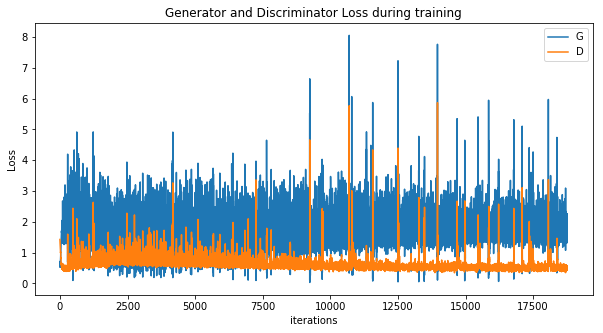

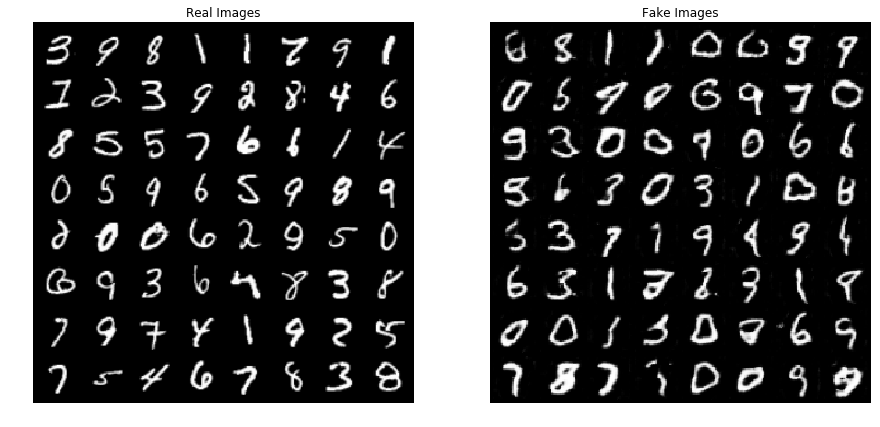

In [3]:
def train():
    """Build, train GAN."""    
    # Load dataset
    trainLoader, testLoader = load_dataset(BS)
    
    # Decide which device to use
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
    # # Create a batch of data
    # realBatch = next(iter(trainLoader))
    # assert len(realBatch[0]) == 128
    # assert len(realBatch[1]) == 128
    # assert realBatch[0].size() == torch.Size([128, 1, 32, 32])
    
    # Build and initialize the network
    netG = Generator().to(device)
    netD = Discriminator().to(device)
    netG.apply(weights_init)
    netD.apply(weights_init)
        
    # Initialize BCELoss function
    criterion = nn.BCELoss()
       
    # Create batch of latent vectors
    fixedNoise = torch.randn(64, NZ, device=device)
        
    # Setup Adam optimizers for both G and D
    optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(BETA1, 0.999))
    
    # Training loop
    imgList = []
    DLosses = []
    GLosses = []
    iters = 0
        
    for epoch in range(NUMEPOCHS):
        for i, data in enumerate(trainLoader, 0):
            # (1) Update Discriminator, maximize log(D(x)) + log(1 - D(G(z)))
            # Train with all-real images batch
            netD.zero_grad()
            realImg = data[0].to(device)
            batchSize = realImg.size(0)
            # Use soft labels
            realLabel = torch.full((batchSize,), 1, device=device)
            realLabel = realLabel + torch.randn(batchSize, device=device)/15
            output = netD(realImg).view(-1)
            errDReal = criterion(output, realLabel)
            errDReal.backward()
            D_x = output.mean().item()
             
            # Train with all-fake noises batch
            noise = torch.randn(batchSize, NZ, device=device)
            fakeImg = netG(noise)
            output = netD(fakeImg.detach()).view(-1)
            # Use soft labels
            fakeLabel = torch.full((batchSize,), 0, device=device)
            fakeLabel = fakeLabel + torch.rand(batchSize, device=device)/3
            errDFake = criterion(output, fakeLabel)
            errDFake.backward()
            D_G_z1 = output.mean().item()
            errD = errDReal + errDFake
            # Update Discriminator
            optimizerD.step()
              
            # (2) Update Generator, maximize log(D(G(z)))
            netG.zero_grad()
            output = netD(fakeImg).view(-1)
            errG = criterion(output, realLabel)
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update Generator
            optimizerG.step()
              
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D = %.4f\tLoss_G = %.4f\tD(x) = %.4f\tD(G(z)) = %.4f / %.4f' 
                      % (epoch, NUMEPOCHS, i, len(trainLoader), errD.item(), 
                         errG.item(), D_x, D_G_z1, D_G_z2))
            
            # Save loss for plotting later
            GLosses.append(errG.item())
            DLosses.append(errD.item())
             
            # Check how netG is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == NUMEPOCHS - 1) and 
                                      (i == len(trainLoader) - 1)):
                with torch.no_grad():
                    fake = netG(fixedNoise).detach().cpu()
                    imgList.append(vutils.make_grid(fake, padding=2, normalize=True))
            iters += 1
                
    # Save the network
    torch.save(netG.state_dict(), PATH+'netG.pt')
    torch.save(netD.state_dict(), PATH+'netD.pt')
    
    # Plot of Discriminator and Generator's losses  
    plt.figure(figsize=(10, 5))
    plt.title('Generator and Discriminator Loss during training')
    plt.plot(GLosses, label='G')
    plt.plot(DLosses, label='D')
    plt.xlabel('iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()     
        
    # Real image versus fake images
    realBatch = next(iter(trainLoader))
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title('Real Images')
    plt.imshow(np.transpose(vutils.make_grid(realBatch[0].to(device)[:64], padding=5, 
                                    normalize=True).cpu(),(1,2,0)))
    
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title('Fake Images')
    plt.imshow(np.transpose(imgList[-1], (1,2,0)))
    plt.show()
    
    
# Train DCGAN normally 
train()

[0/20][0/938]	Loss_D = 1.4351	Loss_G = 0.7568	D(x) = 0.4725	D(G(z)) = 0.4852 / 0.4697
[0/20][50/938]	Loss_D = 0.5510	Loss_G = 1.5815	D(x) = 0.9315	D(G(z)) = 0.2117 / 0.2074
[0/20][100/938]	Loss_D = 0.5268	Loss_G = 1.8318	D(x) = 0.9566	D(G(z)) = 0.1216 / 0.1597
[0/20][150/938]	Loss_D = 0.4572	Loss_G = 1.9149	D(x) = 0.9808	D(G(z)) = 0.1728 / 0.1474
[0/20][200/938]	Loss_D = 0.4670	Loss_G = 1.8567	D(x) = 0.9790	D(G(z)) = 0.1583 / 0.1556
[0/20][250/938]	Loss_D = 0.5148	Loss_G = 1.7912	D(x) = 0.9851	D(G(z)) = 0.1743 / 0.1667
[0/20][300/938]	Loss_D = 0.7047	Loss_G = 1.4361	D(x) = 0.8648	D(G(z)) = 0.0879 / 0.2384
[0/20][350/938]	Loss_D = 0.4742	Loss_G = 1.7849	D(x) = 0.9796	D(G(z)) = 0.2313 / 0.1704
[0/20][400/938]	Loss_D = 0.5818	Loss_G = 2.0044	D(x) = 0.9624	D(G(z)) = 0.2486 / 0.1375
[0/20][450/938]	Loss_D = 0.5353	Loss_G = 2.2386	D(x) = 0.9792	D(G(z)) = 0.2583 / 0.1085
[0/20][500/938]	Loss_D = 0.4579	Loss_G = 1.9430	D(x) = 0.9671	D(G(z)) = 0.2065 / 0.1474
[0/20][550/938]	Loss_D = 0.4505	Los

[4/20][900/938]	Loss_D = 0.6298	Loss_G = 1.6448	D(x) = 0.9561	D(G(z)) = 0.2930 / 0.2001
[5/20][0/938]	Loss_D = 0.7875	Loss_G = 2.3886	D(x) = 0.9763	D(G(z)) = 0.4711 / 0.0952
[5/20][50/938]	Loss_D = 0.6238	Loss_G = 1.3114	D(x) = 0.8990	D(G(z)) = 0.1965 / 0.2776
[5/20][100/938]	Loss_D = 0.6454	Loss_G = 1.6266	D(x) = 0.9128	D(G(z)) = 0.2308 / 0.2000
[5/20][150/938]	Loss_D = 0.5951	Loss_G = 1.8387	D(x) = 0.9415	D(G(z)) = 0.1776 / 0.1640
[5/20][200/938]	Loss_D = 0.6181	Loss_G = 1.4850	D(x) = 0.9204	D(G(z)) = 0.2587 / 0.2357
[5/20][250/938]	Loss_D = 0.6417	Loss_G = 1.5885	D(x) = 0.9429	D(G(z)) = 0.2580 / 0.2066
[5/20][300/938]	Loss_D = 1.1515	Loss_G = 1.6551	D(x) = 0.7842	D(G(z)) = 0.2085 / 0.2030
[5/20][350/938]	Loss_D = 0.6757	Loss_G = 1.8505	D(x) = 0.9552	D(G(z)) = 0.2388 / 0.1623
[5/20][400/938]	Loss_D = 0.6677	Loss_G = 1.2369	D(x) = 0.9293	D(G(z)) = 0.2666 / 0.2986
[5/20][450/938]	Loss_D = 0.6333	Loss_G = 2.1100	D(x) = 0.9381	D(G(z)) = 0.3087 / 0.1306
[5/20][500/938]	Loss_D = 0.6312	Los

[9/20][850/938]	Loss_D = 0.5055	Loss_G = 1.7901	D(x) = 0.9697	D(G(z)) = 0.1353 / 0.1727
[9/20][900/938]	Loss_D = 0.5218	Loss_G = 1.6565	D(x) = 0.9831	D(G(z)) = 0.2096 / 0.1979
[10/20][0/938]	Loss_D = 0.5993	Loss_G = 2.0863	D(x) = 0.9656	D(G(z)) = 0.2250 / 0.1260
[10/20][50/938]	Loss_D = 0.4906	Loss_G = 1.8797	D(x) = 0.9810	D(G(z)) = 0.1517 / 0.1561
[10/20][100/938]	Loss_D = 0.4922	Loss_G = 1.8152	D(x) = 0.9752	D(G(z)) = 0.1262 / 0.1663
[10/20][150/938]	Loss_D = 0.5169	Loss_G = 1.6978	D(x) = 0.9676	D(G(z)) = 0.1619 / 0.1881
[10/20][200/938]	Loss_D = 0.4923	Loss_G = 1.6949	D(x) = 0.9743	D(G(z)) = 0.1961 / 0.1897
[10/20][250/938]	Loss_D = 0.4733	Loss_G = 2.0443	D(x) = 0.9885	D(G(z)) = 0.2411 / 0.1346
[10/20][300/938]	Loss_D = 0.6197	Loss_G = 1.4017	D(x) = 0.8901	D(G(z)) = 0.1635 / 0.2518
[10/20][350/938]	Loss_D = 0.5261	Loss_G = 1.6289	D(x) = 0.9394	D(G(z)) = 0.1985 / 0.2017
[10/20][400/938]	Loss_D = 0.7636	Loss_G = 1.2422	D(x) = 0.8675	D(G(z)) = 0.2897 / 0.2960
[10/20][450/938]	Loss_D = 

[14/20][750/938]	Loss_D = 0.4275	Loss_G = 1.7209	D(x) = 0.9863	D(G(z)) = 0.1648 / 0.1858
[14/20][800/938]	Loss_D = 0.5713	Loss_G = 1.8554	D(x) = 0.9950	D(G(z)) = 0.2736 / 0.1603
[14/20][850/938]	Loss_D = 0.5193	Loss_G = 1.5581	D(x) = 0.9232	D(G(z)) = 0.2377 / 0.2226
[14/20][900/938]	Loss_D = 0.4808	Loss_G = 1.6580	D(x) = 0.9807	D(G(z)) = 0.1506 / 0.1999
[15/20][0/938]	Loss_D = 0.5107	Loss_G = 1.6164	D(x) = 0.9501	D(G(z)) = 0.1742 / 0.2027
[15/20][50/938]	Loss_D = 0.6374	Loss_G = 1.5028	D(x) = 0.9421	D(G(z)) = 0.1969 / 0.2257
[15/20][100/938]	Loss_D = 0.4486	Loss_G = 1.7893	D(x) = 0.9892	D(G(z)) = 0.1645 / 0.1717
[15/20][150/938]	Loss_D = 0.4759	Loss_G = 1.7446	D(x) = 0.9935	D(G(z)) = 0.2166 / 0.1788
[15/20][200/938]	Loss_D = 0.4486	Loss_G = 1.9101	D(x) = 0.9936	D(G(z)) = 0.1803 / 0.1508
[15/20][250/938]	Loss_D = 0.5368	Loss_G = 1.4527	D(x) = 0.9401	D(G(z)) = 0.2172 / 0.2409
[15/20][300/938]	Loss_D = 0.5435	Loss_G = 1.9131	D(x) = 0.9914	D(G(z)) = 0.2061 / 0.1479
[15/20][350/938]	Loss_D 

[19/20][650/938]	Loss_D = 0.3959	Loss_G = 1.6838	D(x) = 0.9859	D(G(z)) = 0.1731 / 0.1937
[19/20][700/938]	Loss_D = 0.6075	Loss_G = 1.7892	D(x) = 0.9952	D(G(z)) = 0.2259 / 0.1653
[19/20][750/938]	Loss_D = 0.5676	Loss_G = 1.9284	D(x) = 0.9938	D(G(z)) = 0.1677 / 0.1438
[19/20][800/938]	Loss_D = 0.4971	Loss_G = 1.8539	D(x) = 0.9944	D(G(z)) = 0.2395 / 0.1595
[19/20][850/938]	Loss_D = 0.5072	Loss_G = 1.8811	D(x) = 0.9921	D(G(z)) = 0.1619 / 0.1538
[19/20][900/938]	Loss_D = 0.4648	Loss_G = 1.6469	D(x) = 0.9962	D(G(z)) = 0.2047 / 0.1974


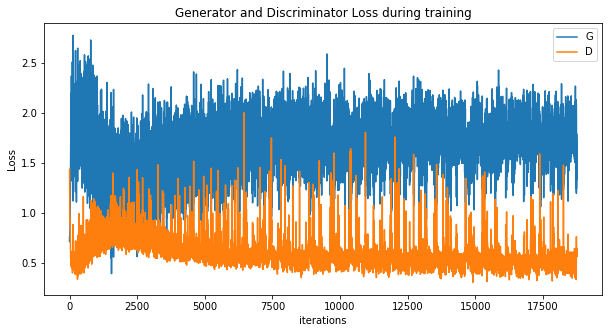

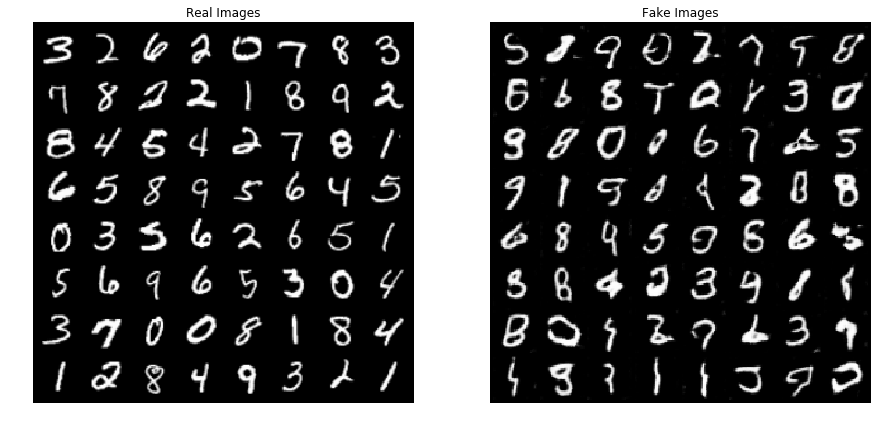

In [4]:
def train_with_GMAN():
    """Build, train GAN with GMAN."""    
    # Load dataset
    trainLoader, testLoader = load_dataset(BS)
    
    # Decide which device to use
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    #     # Create a batch of data
    #     realBatch = next(iter(trainLoader))
    #     assert len(realBatch[0]) == 128
    #     assert len(realBatch[1]) == 128
    #     assert realBatch[0].size() == torch.Size([128, 1, 32, 32])
    
    # Build and initialize the network
    MnetG = Generator().to(device)
    netD1 = Discriminator().to(device)
    netD2 = Discriminator().to(device)
    netD3 = Discriminator().to(device)
    netD4 = Discriminator().to(device)
    netD5 = Discriminator().to(device)
    
    MnetG.apply(weights_init)
    netD1.apply(weights_init)
    netD2.apply(weights_init)
    netD3.apply(weights_init)
    netD4.apply(weights_init)
    netD5.apply(weights_init)
    
    # Initialize BCELoss function
    criterion = nn.BCELoss()
    
    # Create batch of latent vectors
    fixedNoise = torch.randn(64, NZ, device=device)
    
    # Setup Adam optimizers for both G and D
    optimizerG = optim.Adam(MnetG.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimizerD1 = optim.Adam(netD1.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimizerD2 = optim.Adam(netD2.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimizerD3 = optim.Adam(netD3.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimizerD4 = optim.Adam(netD4.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimizerD5 = optim.Adam(netD5.parameters(), lr=LR, betas=(BETA1, 0.999))
    
    # Training loop
    imgList = []
    DLosses = []
    GLosses = []
    iters = 0
    
    for epoch in range(NUMEPOCHS):
        for i, data in enumerate(trainLoader, 0):
            # (1) Update Discriminator, maximize log(D(x)) + log(1 - D(G(z)))
            # Train with all-real images batch
            netD1.zero_grad()
            netD2.zero_grad()
            netD3.zero_grad()
            netD4.zero_grad()
            netD5.zero_grad()
    
            optimizerD1.zero_grad()
            optimizerD2.zero_grad()  
            optimizerD3.zero_grad()
            optimizerD4.zero_grad()
            optimizerD5.zero_grad()
    
            realImg = data[0].to(device)
            batchSize = realImg.size(0)
            # Use soft labels
            realLabel = torch.full((batchSize,), 1, device = device)
            realLabel = realLabel + torch.randn(batchSize, device=device)/15
    
            noise = torch.randn(batchSize, NZ, device=device)
            fakeImg = MnetG(noise)
            # Use soft labels
            fakeLabel = torch.full((batchSize,), 0, device=device)
            fakeLabel = fakeLabel + torch.rand(batchSize, device=device)/3
    
            # Update all discriminators with batch of real and then fake data
            output1 = netD1(realImg).view(-1)
            errD1Real = criterion(output1, realLabel)
    
            output2 = netD2(realImg).view(-1)
            errD2Real = criterion(output2, realLabel)
    
            output3 = netD3(realImg).view(-1)
            errD3Real = criterion(output3, realLabel)
    
            output4 = netD4(realImg).view(-1)
            errD4Real = criterion(output4, realLabel)
    
            output5 = netD5(realImg).view(-1)
            errD5Real = criterion(output5, realLabel)
    
            output = (output1 + output2 + output3 + output4 + output5)/5
            D_x = output.mean().item()
    
            output1 = netD1(fakeImg.detach()).view(-1)
            errD1Fake = criterion(output1, fakeLabel)
            errD1 = errD1Real + errD1Fake
            errD1.backward()
            optimizerD1.step()
    
            output2 = netD2(fakeImg.detach()).view(-1)
            errD2Fake = criterion(output2, fakeLabel)
            errD2 = errD2Real + errD2Fake
            errD2.backward()
            optimizerD2.step()
    
            output3 = netD3(fakeImg.detach()).view(-1)
            errD3Fake = criterion(output3, fakeLabel)
            errD3 = errD3Real + errD3Fake
            errD3.backward()
            optimizerD3.step()
    
            output4 = netD4(fakeImg.detach()).view(-1)
            errD4Fake = criterion(output4, fakeLabel)
            errD4 = errD4Real + errD4Fake
            errD4.backward()
            optimizerD4.step()
    
            output5 = netD5(fakeImg.detach()).view(-1)
            errD5Fake = criterion(output5, fakeLabel)
            errD5 = errD5Real + errD5Fake
            errD5.backward()
            optimizerD5.step()
    
            output = 0.2*(output1+output2+output3+output4+output5)
            D_G_z1 = output.mean().item()
    
            errD = (errD1 + errD2 + errD3 + errD4 + errD5) / 5
    
            # (2) Update Generator, maximize log(D(G(z)))
            MnetG.zero_grad()
            output1 = netD1(fakeImg).view(-1)
            output2 = netD2(fakeImg).view(-1)
            output3 = netD3(fakeImg).view(-1)
            output4 = netD4(fakeImg).view(-1)
            output5 = netD5(fakeImg).view(-1)
    
            errG1 = criterion(output1, realLabel)
            errG2 = criterion(output2, realLabel)
            errG3 = criterion(output3, realLabel)
            errG4 = criterion(output4, realLabel)
            errG5 = criterion(output5, realLabel)
            errG = (errG1 + errG2 + errG3 + errG4 + errG5)/5
            output = (output1 + output2 + output3 + output4 + output5)/5 
            errG = criterion(output, realLabel)
            errG.backward()
            optimizerG.step()
            D_G_z2 = output.mean().item()
            # Update Generator
            #optimizerG.step()
    
    
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D = %.4f\tLoss_G = %.4f\tD(x) = %.4f\tD(G(z)) = %.4f / %.4f' 
                      % (epoch, NUMEPOCHS, i, len(trainLoader), errD.item(), 
                         errG.item(), D_x, D_G_z1, D_G_z2))  
    
            # Save loss for plotting later
            GLosses.append(errG.item())
            DLosses.append(errD.item())
    
            # Check how MnetG is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == NUMEPOCHS - 1) and 
                                      (i == len(trainLoader) - 1)):
                with torch.no_grad():
                    fake = MnetG(fixedNoise).detach().cpu()
                    imgList.append(vutils.make_grid(fake, padding=2, 
                                                    normalize=True))
            iters += 1
    
    torch.save(MnetG.state_dict(), PATH+'MnetG.pt')
    torch.save(netD1.state_dict(), PATH+'netD1.pt')
    torch.save(netD2.state_dict(), PATH+'netD2.pt')
    torch.save(netD3.state_dict(), PATH+'netD3.pt')
    torch.save(netD4.state_dict(), PATH+'netD4.pt')
    torch.save(netD5.state_dict(), PATH+'netD5.pt')
    
    # Plot of Discriminator and Generator's losses  
    plt.figure(figsize=(10, 5))
    plt.title('Generator and Discriminator Loss during training')
    plt.plot(GLosses, label='G')
    plt.plot(DLosses, label='D')
    plt.xlabel('iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()     
    
    # Real image versus fake images
    realBatch = next(iter(trainLoader))
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title('Real Images')
    plt.imshow(np.transpose(vutils.make_grid(realBatch[0].to(device)[:64], padding=5, 
                                    normalize=True).cpu(),(1,2,0)))
    
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title('Fake Images')
    plt.imshow(np.transpose(imgList[-1], (1,2,0)))
    plt.show()


# Train DCGAN with GMAN
train_with_GMAN()

In [5]:
# Evaluate the performance of DCGAN trained normally
netG = Generator()
netG.load_state_dict(torch.load(PATH+'netG.pt'))
netG.eval()

netD = Discriminator()
netD.load_state_dict(torch.load(PATH+'netD.pt'))
netD.eval()

tempD = []
D1 = []

# Load dataset
trainLoader, testLoader = load_dataset(BS)

# Decide which device to use
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
netG.to(device)
netD.to(device)

#test all real data on discriminator of GAN
for epoch in range(NUMEPOCHS):
    for i, (data, target) in enumerate(testLoader, 0):
        realImg = data.to(device)
        batchSize = realImg.size(0)
        realLabel = torch.full((batchSize,), 1, device = device)
        target = target.view(-1, 1)
        output = netD(realImg).view(-1)
        fakeLabel = torch.full((batchSize,), 0, device=device)
        D_x = output.mean().item()
        tempD.append(D_x)
    av_d = sum(tempD)/len(tempD)
    D1.append(av_d)
    
D1_test = sum(D1)/len(D1)

print(D1_test)

0.778889353269256


In [6]:
# Evaluate the performance of DCGAN trained with GMAN
MnetG = Generator()
MnetG.load_state_dict(torch.load(PATH+'MnetG.pt'))
MnetG.eval()
MnetG.to(device)

netD1 = Discriminator()
netD1.load_state_dict(torch.load(PATH+'netD1.pt'))
netD1.eval()
netD1.to(device)

netD2 = Discriminator()
netD2.load_state_dict(torch.load(PATH+'netD2.pt'))
netD2.eval()
netD2.to(device)

netD3 = Discriminator()
netD3.load_state_dict(torch.load(PATH+'netD3.pt'))
netD3.eval()
netD3.to(device)

netD4 = Discriminator()
netD4.load_state_dict(torch.load(PATH+'netD4.pt'))
netD4.eval()
netD4.to(device)

netD5 = Discriminator()
netD5.load_state_dict(torch.load(PATH+'netD5.pt'))
netD5.eval()
netD5.to(device)

tempD = []
D2 = []

#test all real data on discriminator of GMAN
for epoch in range(NUMEPOCHS):
    for i, data in enumerate(testLoader, 0):
        realImg = data[0].to(device)
        batchSize = realImg.size(0)
        realLabel = torch.full((batchSize,), 1, device = device)
        output1 = netD1(realImg).view(-1)
        output2 = netD2(realImg).view(-1)
        output3 = netD3(realImg).view(-1)
        output4 = netD4(realImg).view(-1)
        output5 = netD5(realImg).view(-1)
        output = (output1 + output2 + output3 + output4 + output5)/5
        D_x = output.mean().item()
        tempD.append(D_x)
    av_d = sum(tempD)/len(tempD)
    D2.append(av_d)
D2_test = sum(D2)/len(D2)

print(D2_test)

0.642879181450918


In [7]:
print('test rate =', D1_test/D2_test, 'close to 1')

test rate = 1.2115641254883627 close to 1


In [8]:
imgList_gan = []
imgList_gman = []
temp_rs = []
criterion = nn.BCELoss()
Label = torch.full((64,), 1, device=device)

#Calculate classification error rate for G1 in D2 and G2 in D1
for i in range(1,200):
    fixedNoise = torch.randn(64, NZ,device=device) #generate fake image using 2 generators with same noise input
    fake_gan = netG(fixedNoise).detach()
    fake_gman = MnetG(fixedNoise).detach()
    output1 = netD(fake_gman.detach()).view(-1)
    #Dgan_Ggman = output1.mean().item()
    errD1 = criterion(output1, Label)   #Classification error of generator of GAN
    outputm1 = netD1(fake_gan.detach()).view(-1)
    outputm2 = netD2(fake_gan.detach()).view(-1)
    outputm3 = netD3(fake_gan.detach()).view(-1)
    outputm4 = netD4(fake_gan.detach()).view(-1)
    outputm5 = netD5(fake_gan.detach()).view(-1)
    output2 = (outputm1+outputm2+outputm3+outputm4+outputm5)/5
    #Dgman_Ggan = output2.mean().item()
    errD2 = criterion(output2, Label) #Classification error of generator of GMAN
    r_s = errD1/errD2
    temp_rs.append(r_s)
    
r_sample = sum(temp_rs)/len(temp_rs)

print('sample rate =', r_sample)
if r_sample < 1:
    print('GAN Win~')
else:
    print('GMAN win~')
    

sample rate = tensor(1.0165, device='cuda:0')
GMAN win~
